In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from amb import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
age_palette = get_age_palette()

In [2]:
ct = 'Oligo_NN'

## identify age-degs

In [3]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [4]:
result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
result['log2(18mo/2mo)'] = np.log2(result['fc'])
result['-log10(padj)'] = -np.log10(result['fdr'])
result.head()

,fc,fdr,log2(18mo/2mo),-log10(padj)
gene,,,,
Xkr4,1.049802,1.0,0.070117,-0.0
Gm1992,0.599645,1.0,-0.737820,-0.0
Gm19938,1.586203,1.0,0.665577,-0.0
Mrpl15,1.655358,1.0,0.727144,-0.0
Lypla1,0.979813,1.0,-0.029422,-0.0


In [5]:
sig_result = result[(result['fdr'] < 0.0001) & (abs(result['log2(18mo/2mo)']) > 1)]
sig_result.shape

(219, 4)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


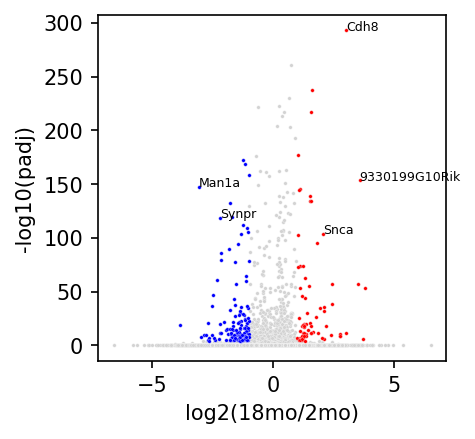

In [6]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 150)
sns.scatterplot(data = result,
                ax = ax,
                color = 'lightgrey',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] > 0],
                ax = ax,
                color = 'red',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] < 0],
                ax = ax,
                color = 'blue',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

for i, row in sig_result.iterrows():
    if row['-log10(padj)'] > 100 and (row['log2(18mo/2mo)'] > 2 or row['log2(18mo/2mo)'] < -2):
        ax.text(row['log2(18mo/2mo)'], row['-log10(padj)'], 
                row.name, 
                color='black', fontsize=6)

## abc score

In [7]:
gene_meta = pd.read_csv('use.mouse_genes.csv', index_col = 0)
gene_name_to_id= {v:k for k,v in gene_meta['gene_name'].to_dict().items()}
slop = 2000
gene_meta['start'] = gene_meta['start'].astype(int) - slop
gene_meta['end'] = gene_meta['end'].astype(int) + slop

In [8]:
up_genes = list(set(sig_result[sig_result['log2(18mo/2mo)'] > 0.5].index) &set(gene_name_to_id.keys()))
down_genes = list(set(sig_result[sig_result['log2(18mo/2mo)'] < -0.5].index) &set(gene_name_to_id.keys()))

In [9]:
young_abc_df = pd.read_csv(f'{ct}.8wk.abc_score.csv', index_col = 0)
old_abc_df = pd.read_csv(f'{ct}.18mo.abc_score.csv', index_col = 0)

In [10]:
young_abc_df['gene_id'] = young_abc_df.index.map(lambda x: x.split('-')[-1])
old_abc_df['gene_id'] = old_abc_df.index.map(lambda x: x.split('-')[-1])

In [11]:
def genome_pos(x):
    _chr, e_start, e_end, gene_id = x.split('-')
    e_start, e_end = int(e_start), int(e_end)
    #gene_start = int(gene_meta.loc[gene_id]['start'])
    #distance = abs(e_start - gene_start)
    return e_start

def pre_use_abs_df(df, gene_list):
    use_df = df[df['gene_id'].isin([gene_name_to_id[gene] for gene in gene_list])]
    use_df['gene_start'] = use_df['gene_id'].map(gene_meta['start'].to_dict())
    use_df['e_start'] = use_df.index.map(lambda x: genome_pos(x))
    use_df['eg_dist'] = abs(use_df['e_start'] - use_df['gene_start'])
    return use_df 

In [12]:
#use_gene_list = non_sig_result.index
use_gene_list = up_genes+down_genes
len(use_gene_list)

219

In [13]:
use_young_abc_df = pre_use_abs_df(young_abc_df, gene_list = use_gene_list)
use_old_abc_df = pre_use_abs_df(old_abc_df, gene_list = use_gene_list)

In [14]:
shared_e_g_pairs = list(set(use_young_abc_df.index) & set(use_old_abc_df.index))
shared_e_g_pairs_num = len(shared_e_g_pairs)
shared_e_g_pairs_num

74710

In [15]:
# old_unique = use_old_abc_df.loc[~use_old_abc_df.index.isin(shared_e_g_pairs)]
# young_unique = use_young_abc_df.loc[~use_young_abc_df.index.isin(shared_e_g_pairs)]

In [16]:
# # Use the venn2 function
# plt.figure(figsize=(4, 3), dpi = 100) 
# venn = venn2(subsets = ((use_young_abc_df.shape[0] - shared_e_g_pairs_num), 
#              (use_old_abc_df.shape[0]-shared_e_g_pairs_num), shared_e_g_pairs_num), 
#              set_colors=(age_palette['2mo'], age_palette['18mo']),
#              set_labels = ('2mo', '18mo'))

# venn.get_patch_by_id('11').set_color('skyblue')
# # venn.get_patch_by_id('10').set_color(age_palette['2mo'])  # This adjusts the fill color for '2mon' only
# # venn.get_patch_by_id('01').set_color(age_palette['18mo']) 
# plt.show()

In [17]:
shared_df=pd.concat([use_old_abc_df.loc[shared_e_g_pairs], use_young_abc_df.loc[shared_e_g_pairs]['0']], axis = 1)

In [18]:
# fig, ax = plt.subplots(figsize=(6,3), dpi = 100)
# sns.distplot(young_unique['eg_dist'], ax = ax, color = age_palette['2mo'])
# sns.distplot(old_unique['eg_dist'], ax = ax, color = age_palette['18mo'])
# sns.distplot(use_old_abc_df.loc[shared_e_g_pairs]['eg_dist'], ax = ax, color = 'skyblue')
# ax.set_xlabel('Enhancer-Gene Distance(bp)')

In [19]:
shared_df.columns = ['8wk', 'gene_id','gene_start','e_start','eg_dist','18mo']

In [20]:
def set_cat(x):
    if x < -cutoff:
        cat = 'young_active'
    elif x > cutoff:
        cat = 'old_active'
    else:
        cat = 'both_active'
    return cat

all_to_plot = []
for gene_id , tmpdf in shared_df.groupby('gene_id'):
    tmpdf['Rank_8wk'] = tmpdf['8wk'].rank()
    tmpdf['Rank_18mo'] = tmpdf['18mo'].rank()
    tmpdf['importance'] = tmpdf['Rank_18mo'] - tmpdf['Rank_8wk'] 
    cutoff = np.quantile(tmpdf['importance'], 0.95)
    tmpdf['cat'] = tmpdf['importance'].apply(lambda x: set_cat(x))
    all_to_plot.append(tmpdf)
all_to_plot = pd.concat(all_to_plot)


In [27]:
all_to_plot['enhancer_id'] = all_to_plot.index.map(lambda x: x.split('-ENS')[0])

In [31]:
def get_length(x):
    _chr, start, end = x.split('-')
    length = int(end) - int(start)
    return length
all_to_plot['enhancer_length'] = all_to_plot['enhancer_id'].apply(lambda x: get_length(x))

<Axes: xlabel='enhancer_length', ylabel='Density'>

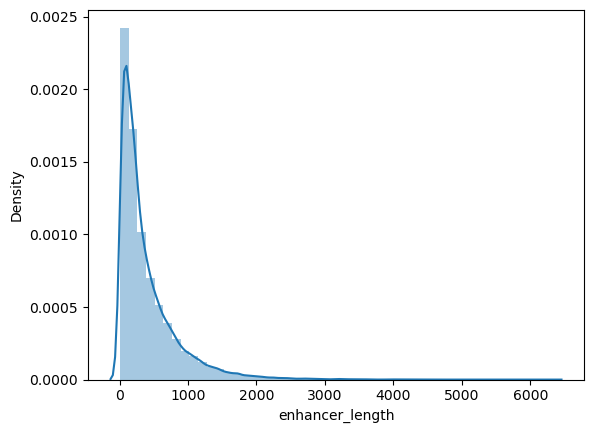

In [33]:
sns.distplot(all_to_plot['enhancer_length'])

Text(0.5, 1.0, 'Enhancer-Gene Distance')

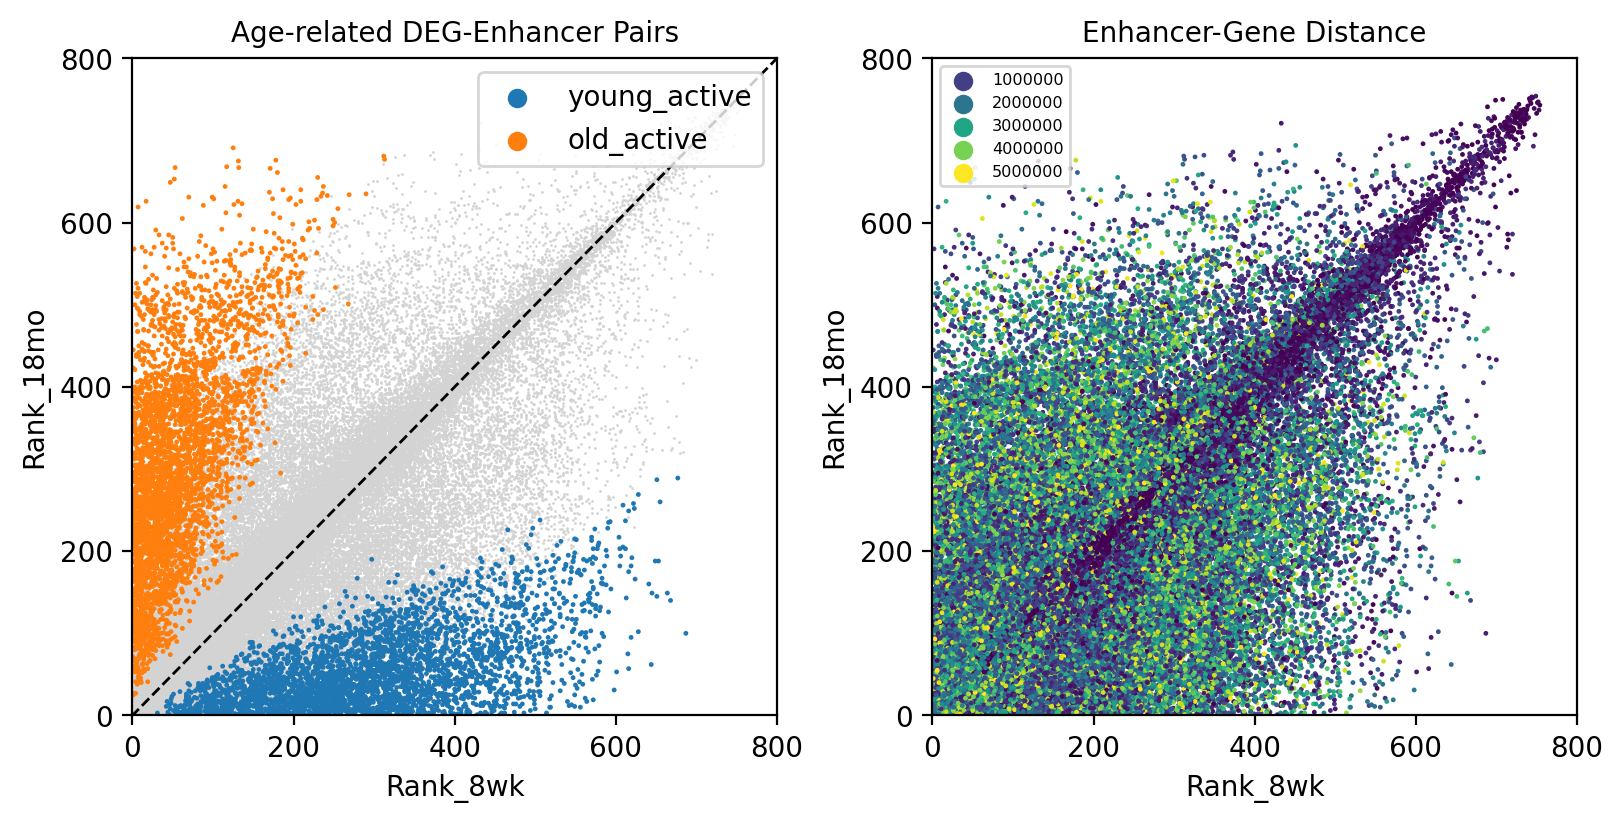

In [46]:
fig, axes = plt.subplots(figsize = (8,4),ncols = 2, dpi = 200, constrained_layout = True)
ax = axes[0]
sns.scatterplot(data = all_to_plot[all_to_plot['cat'] == 'both_active'],
                color = 'lightgrey',
                ax = ax,s =1,
                linewidth = 0,
                x = 'Rank_8wk',
                y = 'Rank_18mo')

sns.scatterplot(data = all_to_plot[all_to_plot['cat'] != 'both_active'],
                hue = 'cat',
                ax = ax,s =3,
                linewidth = 0,
                x = 'Rank_8wk',
                y = 'Rank_18mo')
ax.legend(loc = 'upper right')
#plt.legend(bbox_to_anchor=(0.49, 1), loc='upper left', borderaxespad=0,fontsize='small')
ax.set(xlim = [0,800], ylim = [0,800], xticks = [0,200,400,600,800], yticks = [0,200,400,600, 800])
ax.plot([-1, 800], [-1, 800], ls = '--', c = 'black',lw = 1)
ax.set_title(f"Age-related DEG-Enhancer Pairs", fontsize = 10)

ax = axes[1]
sns.scatterplot(data = all_to_plot,
                hue = 'eg_dist',
                hue_norm = (1e5, 5e6),
                palette = 'viridis',
                ax = ax,s =3,
                legend = True,
                linewidth = 0,
                x = 'Rank_8wk',
                y = 'Rank_18mo')
ax.legend(loc = 'upper left', fontsize = 'xx-small') # bbox_to_anchor=(1, 1)
#plt.legend(bbox_to_anchor=(0.49, 1), loc='upper left', borderaxespad=0,fontsize='small')
ax.set(xlim = [0,800], ylim = [0,800], xticks = [0,200,400,600,800], yticks = [0,200,400,600, 800])
ax.set_title(f"Enhancer-Gene Distance", fontsize = 10)


In [43]:
all_to_plot['rank_diff'] = all_to_plot['Rank_18mo'] - all_to_plot['Rank_8wk']

In [72]:
no_change_group = all_to_plot[abs(all_to_plot['rank_diff']) < 8 ]
no_change_group.shape

(11543, 13)

In [73]:
change_group = all_to_plot[all_to_plot['cat'] != 'both_active']
change_group.shape

(7464, 13)

In [82]:
change_group['eg_dist'].mean()

1956343.9435959272

In [83]:
no_change_group['eg_dist'].mean()

1479525.0774495364

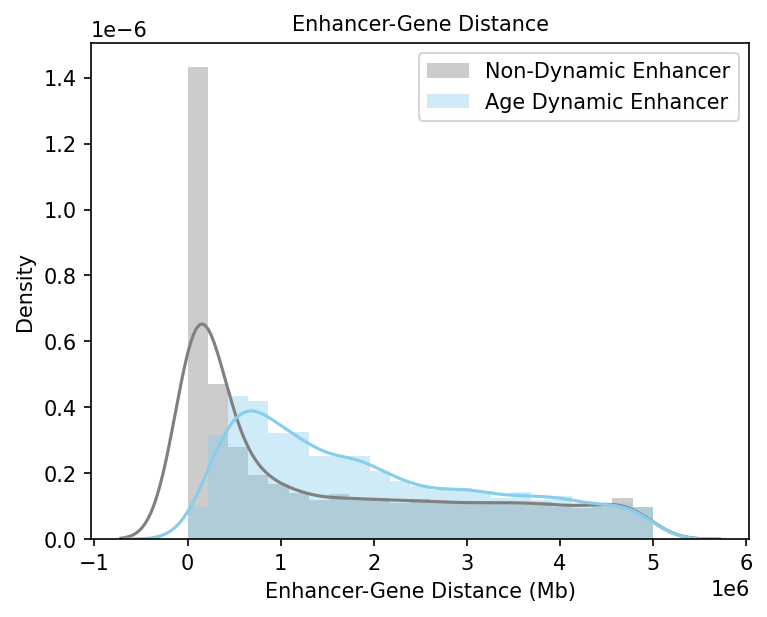

In [80]:
fig, ax = plt.subplots(figsize = (5,4),dpi = 150, constrained_layout = True)
sns.distplot(no_change_group['eg_dist'], color='grey', label='Non-Dynamic Enhancer')
sns.distplot(change_group['eg_dist'], color='skyblue', label='Age Dynamic Enhancer')
ax.set_xlabel('Enhancer-Gene Distance (Mb)')
ax.set_title("Enhancer-Gene Distance", fontsize = 10)
ax.legend()

In [59]:
# sns.distplot(all_to_plot[all_to_plot['cat'] == 'both_active']['eg_dist'], 
#              ax=ax, color='lightgrey', 
#               label='Both Active') #cumulative=True, stat='density', element='poly', fill=False,

# sns.distplot(all_to_plot[all_to_plot['cat'] == 'old_active']['eg_dist'], 
#              ax=ax, color='orange', 
#               label='Old Active') #cumulative=True, stat='density', element='poly', fill=False,

# sns.distplot(all_to_plot[all_to_plot['cat'] == 'young_active']['eg_dist'], 
#              ax=ax, color='blue', 
#               label='Young Active') # cumulative=True, stat='density', element='poly', fill=False,

# #ax.set_xscale('log')
# ax.set_xlabel('Enhancer-Gene Distance (Mb)')
# ax.set_title(f"Enhancer-Gene Distance", fontsize = 10)
# ax.legend()